[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Collaborative filtering: refactoring the code
-----

In this practical, you will need to refactor the code seen during the lesson in order to deal with the [Movielens 1M Dataset](https://grouplens.org/datasets/movielens/1m/)

## 1. Preparations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import imp
import numpy as np

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line need to be changed:
data_folder = '/content/'


ML_1M_URL = "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
ML_1M_FILENAME = op.join(data_folder,ML_1M_URL.rsplit('/', 1)[1])
ML_1M_FOLDER = op.join(data_folder,'ml-1m')

/tmp/ipykernel_42971/3635309985.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
if not op.exists(ML_1M_FILENAME):
    print('Downloading %s to %s...' % (ML_1M_URL, ML_1M_FILENAME))
    urlretrieve(ML_1M_URL, ML_1M_FILENAME)

if not op.exists(ML_1M_FOLDER):
    print('Extracting %s to %s...' % (ML_1M_FILENAME, ML_1M_FOLDER))
    ZipFile(ML_1M_FILENAME).extractall(data_folder)

## 2. Data analysis and formating

As in the lesson, we start by loading the data with [Python Data Analysis Library](http://pandas.pydata.org/)

In [3]:
import pandas as pd
all_ratings = pd.read_csv(op.join(ML_1M_FOLDER, 'ratings.dat'), sep='::',
                          names=["user_id", "item_id", "ratings", "timestamp"],engine='python')
all_ratings.head()

,user_id,item_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
list_movies_names = []
list_item_ids = []
with open(op.join(ML_1M_FOLDER, 'movies.dat'), encoding = "ISO-8859-1") as fp:
    for line in fp:
        list_item_ids.append(line.split('::')[0])
        list_movies_names.append(line.split('::')[1])
        
movies_names = pd.DataFrame(list(zip(list_item_ids, list_movies_names)), 
               columns =['item_id', 'item_name']) 
movies_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


Here we add the title of the movies to the data.

In [5]:
movies_names['item_id']=movies_names['item_id'].astype(int)
all_ratings['item_id']=all_ratings['item_id'].astype(int)
all_ratings = all_ratings.merge(movies_names,on='item_id')

In [6]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975)
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975)
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975)
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975)
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975)


The dataframe `all_ratings` contains all the raw data for our problem.

In [7]:
#number of entries
len(all_ratings)

1000209

In [8]:
all_ratings['ratings'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

In [9]:
all_ratings['ratings'].unique()

array([5, 4, 3, 2, 1])

In [10]:
all_ratings['user_id'].describe()

count    1.000209e+06
mean     3.024512e+03
std      1.728413e+03
min      1.000000e+00
25%      1.506000e+03
50%      3.070000e+03
75%      4.476000e+03
max      6.040000e+03
Name: user_id, dtype: float64

In [11]:
# number of unique users
total_user_id = len(all_ratings['user_id'].unique())
print(total_user_id)

6040


We see that as in the lesson, the users seem to be indexed from 1 to 6040. Let's check that below.

In [12]:
list_user_id = list(all_ratings['user_id'].unique())
list_user_id.sort()

In [13]:
for i,j in enumerate(list_user_id):
    if j != i+1:
        print(i,j) 

We create a new column `user_num` to get an index from 0 to 6039 for users:

In [14]:
all_ratings['user_num'] = all_ratings['user_id'].apply(lambda x :x-1)

In [15]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),1
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),11
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),14
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),16


We now look at movies.

In [16]:
all_ratings['item_id'].describe()

count    1.000209e+06
mean     1.865540e+03
std      1.096041e+03
min      1.000000e+00
25%      1.030000e+03
50%      1.835000e+03
75%      2.770000e+03
max      3.952000e+03
Name: item_id, dtype: float64

In [17]:
# number of unique rated items
total_item_id = len(all_ratings['item_id'].unique())
print(total_item_id)

3706


Here there is a clear problem: there are 3706 different movies but the range of `item_id` starts at 1 and ends at 3952. So there are gaps, so the first thing you will need to do is to create a new column `item_num` so that all movies are indexed from 0 to 3705.

In [18]:
itemnum_2_itemid = list(all_ratings['item_id'].unique())
itemnum_2_itemid.sort()
itemid_2_itemnum = {c:i for i,c in enumerate(itemnum_2_itemid)}
all_ratings['item_num'] = all_ratings['item_id'].apply(lambda x: itemid_2_itemnum[x])

This function will verify that your result is correct.

In [19]:
def check_ratings_num(df):
    item_num = set(df['item_num'])
    if item_num == set(range(len(item_num))):
        return True
    else:
        return False

In [20]:
check_ratings_num(all_ratings)

True

In [21]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num,item_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0,1104
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),1,1104
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),11,1104
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),14,1104
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),16,1104


Now we will split the data in _train_, _val_ and _test_ be using a pre-defined function from [scikit-learn](http://scikit-learn.org/stable/)

In [22]:
from sklearn.model_selection import train_test_split

ratings_trainval, ratings_test = train_test_split(all_ratings, test_size=0.1, random_state=42)

ratings_train, ratings_val = train_test_split(ratings_trainval, test_size=0.1, random_state=42)

## 3. The model

We will now modify a bit the `FactorizationModel` class seen during the lesson. Internally, we will still use the `Model_dot` but now we use the PyTorch dataloader.

In [23]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
def df_2_tensor(df, device):
    # return a triplet user_num, item_num, rating from the dataframe
    user_num = np.asarray(df['user_num'])
    item_num = np.asarray(df['item_num'])
    rating = np.asarray(df['ratings'])
    return torch.from_numpy(user_num).to(device), torch.from_numpy(item_num).to(device), torch.from_numpy(rating).to(device)

Below, we construct 3 tensors containing the `user_num`, `item_num` and `rating` for the training set. All tensors have the same shape so that `train_user_num[i]` watched `train_item_num[i]` and gave a rating of `train_rating[i]`.

In [26]:
train_user_num, train_item_num, train_rating = df_2_tensor(ratings_train,device)

We now do the same thing for the validation and test sets.

In [27]:
val_user_num, val_item_num, val_rating = df_2_tensor(ratings_val,device)
test_user_num, test_item_num, test_rating = df_2_tensor(ratings_test,device)

The code below is taken from the lesson

In [28]:
class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    """
    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)


class ZeroEmbedding(nn.Embedding):
    """
    Used for biases.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)

In [29]:
class DotModel(nn.Module):
    
    def __init__(self,
                 num_users,
                 num_items,
                 embedding_dim=32):
        
        super(DotModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        self.user_embeddings = ScaledEmbedding(num_users, embedding_dim)
        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim)
        self.user_biases = ZeroEmbedding(num_users, 1)
        self.item_biases = ZeroEmbedding(num_items, 1)
                
        
    def forward(self, user_ids, item_ids):
        #
        # your code
        #
        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)

        user_embedding = user_embedding
        item_embedding = item_embedding

        user_bias = self.user_biases(user_ids).squeeze()
        item_bias = self.item_biases(item_ids).squeeze()

        dot = (user_embedding * item_embedding).sum(1)
        
        res = dot + user_bias + item_bias

        return res

In [30]:
net = DotModel(total_user_id,total_item_id).to(device)

Now test your network on a small batch.

In [31]:
predictions = net(train_user_num[:5], train_item_num[:5])
predictions

tensor([ 0.0078,  0.0003, -0.0097,  0.0069, -0.0105], device='cuda:0',
       grad_fn=<AddBackward0>)

In [32]:
def regression_loss(predicted_ratings, observed_ratings):
    return ((observed_ratings - predicted_ratings) ** 2).mean()

In [33]:
loss_fn = regression_loss
loss = loss_fn(predictions, train_rating[:5])
loss

tensor(12.0166, device='cuda:0', grad_fn=<MeanBackward0>)

Now you need to construct a dataset and a dataloader. For this, you can define a first function taking as arguments the tensors defined above and returning a list; then a second function taking as argument a dataset, the batchsize and a boolean for the shuffling. We will not use anymore the functions `shuffle` and `minibatch` used in the lesson.

In [34]:
def tensor_2_dataset(user,item,rating):
    # your code here
    return list(zip(user,item,rating))
    
def make_dataloader(dataset,bs,shuffle):
    # your code here
    return torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=shuffle)

In [35]:
train_dataset = tensor_2_dataset(train_user_num,train_item_num, train_rating)
val_dataset = tensor_2_dataset(val_user_num,val_item_num,val_rating)
test_dataset = tensor_2_dataset(test_user_num, test_item_num, test_rating)

In [36]:
train_dataloader = make_dataloader(train_dataset,1024,True)
val_dataloader = make_dataloader(val_dataset,1024, False)
test_dataloader = make_dataloader(test_dataset,1024,False)

Here you need to modify the code seen during the lesson:
 - remove the batch_size in the init
 - the fit function should now take as argument a dataloader for the training and a dataloader for the validation. AT the end of each epoch, you run the test method on the validation set. Then you print both the loss on the training set and on the validation set to see if you are overfitting.

In [37]:
class FactorizationModel(object):
    
    def __init__(self, embedding_dim=32, n_iter=10, l2=0.0,
                 learning_rate=1e-2, device=device, net=None, num_users=None,
                 num_items=None,random_state=None):
        
        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._l2 = l2
        self._device = device
        self._num_users = num_users
        self._num_items = num_items
        self._net = net
        self._optimizer = None
        self._loss_func = None
        self._random_state = random_state or np.random.RandomState()
             
        
    def _initialize(self):
        if self._net is None:
            self._net = DotModel(self._num_users, self._num_items, self._embedding_dim).to(self._device)
        
        self._optimizer = optim.Adam(
                self._net.parameters(),
                lr=self._learning_rate,
                weight_decay=self._l2
            )
        
        self._loss_func = regression_loss
        
    
    @property
    def _initialized(self):
        return self._optimizer is not None
    
    def __repr__(self):
        return _repr_model(self)
    
    def fit(self, dataloader, val_dataloader, verbose=True):       
        if not self._initialized:
            self._initialize()
            
        for epoch_num in range(self._n_iter):
            epoch_loss = 0.0
            self._net.train(True)

            #
            # your code
            for (minibatch_num, (batch_user, batch_item, batch_rating)) in enumerate(dataloader):
                predictions = self._net(batch_user,batch_item)
                self._optimizer.zero_grad()
                loss = self._loss_func(predictions,batch_rating)
                epoch_loss += loss.item()
                loss.backward()
                self._optimizer.step()
            #
                
            
            epoch_loss = epoch_loss / (minibatch_num + 1)
            loss_test = self.test(val_dataloader)

            if verbose:
                print('Epoch {}: loss_train {}, loss_val {}'.format(epoch_num, epoch_loss,loss_test))
        
            if np.isnan(epoch_loss) or epoch_loss == 0.0:
                raise ValueError('Degenerate epoch loss: {}'
                                 .format(epoch_loss))
    
    
    def test(self,dataloader, verbose = False):
        self._net.train(False)
        L1loss = torch.nn.L1Loss()
        test_loss = 0.0
        test_mae = 0.0
        #
        # your code here (mae = mean absolute error)
        for (minibatch_num, (batch_user, batch_item, batch_rating)) in enumerate(dataloader):
            predictions = self._net(batch_user,batch_item)
            loss = self._loss_func(predictions,batch_rating)
            test_loss += loss.item()
            test_mae += L1loss(predictions,batch_rating.type(torch.FloatTensor).to(device))
        #
                
        test_loss = test_loss / (minibatch_num + 1)
        test_mae = test_mae / (minibatch_num+1)
        if verbose:
            print(f"RMSE: {np.sqrt(test_loss)}, MAE: {test_mae}")
        return loss.item()

In [38]:
model = FactorizationModel(embedding_dim=50,  # latent dimensionality
                                   n_iter=5,  # number of epochs of training
                                   learning_rate=5e-4,
                                   l2=1e-8,  # strength of L2 regularization
                                   num_users=total_user_id,
                                   num_items=total_item_id)

In [39]:
model.fit(train_dataloader,val_dataloader)

Epoch 0: loss_train 10.483497817407954, loss_val 3.259150505065918
Epoch 1: loss_train 1.7397940213030034, loss_val 1.0772451162338257
Epoch 2: loss_train 0.9825870432335921, loss_val 0.91329026222229
Epoch 3: loss_train 0.8714386894546374, loss_val 0.873589277267456
Epoch 4: loss_train 0.8386065927569313, loss_val 0.8576654195785522


In [40]:
model.fit(train_dataloader,val_dataloader)

Epoch 0: loss_train 0.8233853814878849, loss_val 0.8553363680839539
Epoch 1: loss_train 0.8122792715827624, loss_val 0.8385775685310364
Epoch 2: loss_train 0.8015975057326182, loss_val 0.8299235701560974
Epoch 3: loss_train 0.7913516945760659, loss_val 0.8280952572822571
Epoch 4: loss_train 0.7815644568716636, loss_val 0.8056606650352478


In [41]:
model.fit(train_dataloader,val_dataloader)

Epoch 0: loss_train 0.7725902248663131, loss_val 0.8080278038978577
Epoch 1: loss_train 0.7641085237264633, loss_val 0.7990661263465881
Epoch 2: loss_train 0.7561668316372717, loss_val 0.7914382219314575
Epoch 3: loss_train 0.7482567571028315, loss_val 0.7849618196487427
Epoch 4: loss_train 0.7404139599565304, loss_val 0.7870027422904968


In [42]:
model.fit(train_dataloader,val_dataloader)

Epoch 0: loss_train 0.7319444524820404, loss_val 0.7801695466041565
Epoch 1: loss_train 0.7233793336634684, loss_val 0.7774919867515564
Epoch 2: loss_train 0.7141669735011428, loss_val 0.7649633884429932
Epoch 3: loss_train 0.7041290485196643, loss_val 0.771318256855011
Epoch 4: loss_train 0.6933240536035914, loss_val 0.7632575631141663


In [43]:
_= model.test(test_dataloader,True)

RMSE: 0.867548660282591, MAE: 0.681933581829071


Play with the parameter to beat the benchmarks presented here: [Surprise](https://github.com/NicolasHug/Surprise)

## 4. Best and worst movies

Now you need to rank the movies according to their bias. For this, you need to recover the biases of the movies, make a list of the pairs `[name of the movie, its bias]` and then sort this list according to the biases. You can use the method sort of a list.

In [44]:
item_bias_np = model._net.item_biases.weight.data.cpu().numpy()
item_bias_np = item_bias_np.squeeze()
np.asarray(all_ratings[['item_name', 'item_num']])

array([["One Flew Over the Cuckoo's Nest (1975)", 1104],
       ["One Flew Over the Cuckoo's Nest (1975)", 1104],
       ["One Flew Over the Cuckoo's Nest (1975)", 1104],
       ...,
       ['White Boys (1999)', 2638],
       ['One Little Indian (1973)', 3367],
       ['Five Wives, Three Secretaries and Me (1998)', 2702]],
      dtype=object)

In [45]:
numitem_2_name = {i:name for name,i in np.asarray(all_ratings[['item_name', 'item_num']])}
name_2_numitem = {name:i for name,i in np.asarray(all_ratings[['item_name', 'item_num']])}

In [46]:
list_name_bias = [[name, item_bias_np[name_2_numitem[name]]] for name in list(ratings_train['item_name'].unique())]

In [47]:
list_name_bias[:4]

[['Flawless (1999)', 0.1841258],
 ['Grand Day Out, A (1992)', 0.37905848],
 ['Platoon (1986)', 0.3168986],
 ['Contender, The (2000)', 0.30273548]]

In [48]:
list_name_bias.sort(key= lambda x: x[1])

In [49]:
list_name_bias[:10]

[['Mr. Wrong (1996)', 0.03592497],
 ['Children of the Corn IV: The Gathering (1996)', 0.044052407],
 ['Free Willy 3: The Rescue (1997)', 0.04690211],
 ['August (1996)', 0.047154162],
 ['Elstree Calling (1930)', 0.048291106],
 ["Puppet Master III: Toulon's Revenge (1991)", 0.053831235],
 ['Tokyo Fist (1995)', 0.05392649],
 ['Fantastic Night, The (La Nuit Fantastique) (1949)', 0.058136385],
 ['Lost in Space (1998)', 0.0590787],
 ['Problem Child 2 (1991)', 0.059472192]]

In [50]:
list_name_bias[-10:]

[['American Beauty (1999)', 0.47356018],
 ['Matrix, The (1999)', 0.47521988],
 ['Usual Suspects, The (1995)', 0.4803672],
 ['Silence of the Lambs, The (1991)', 0.49111733],
 ['Godfather, The (1972)', 0.49870548],
 ['Star Wars: Episode IV - A New Hope (1977)', 0.5180059],
 ['Raiders of the Lost Ark (1981)', 0.5185158],
 ["Schindler's List (1993)", 0.5215493],
 ['Sixth Sense, The (1999)', 0.52186865],
 ['Shawshank Redemption, The (1994)', 0.53263825]]

## 5. PCA of movies' embeddings

Now you can also plpay with the embeddings learned by your algorithm for the movies.

In [51]:
from sklearn.decomposition import PCA
from operator import itemgetter

In [52]:
item_emb_np = model._net.item_embeddings.weight.data.cpu().numpy()
item_emb_np.shape

(3706, 50)

In [53]:
g = all_ratings.groupby('item_name')['ratings'].count()
most_rated_movies = g.sort_values(ascending=False).index.values[:1000]
most_rated_movies[:10]

array(['American Beauty (1999)',
       'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)', 'Saving Private Ryan (1998)',
       'Terminator 2: Judgment Day (1991)', 'Matrix, The (1999)',
       'Back to the Future (1985)', 'Silence of the Lambs, The (1991)'],
      dtype=object)

In [54]:
most_rated_movies_num = [name_2_numitem[n] for n in most_rated_movies]

In [55]:
pca = PCA(n_components=4)
latent_fac = pca.fit_transform(item_emb_np)

In [56]:
movie_comp = [(f, numitem_2_name[i]) for i,f in enumerate(latent_fac[:,1])]

In [57]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(1.4044963, 'White Boys (1999)'),
 (1.4044892, 'Match, The (1999)'),
 (1.404487, 'Frank and Ollie (1995)'),
 (1.404487, 'Number Seventeen (1932)'),
 (1.4044863, 'Uninvited Guest, An (2000)'),
 (1.4044858, 'Fausto (1993)'),
 (1.4044858, 'Hungarian Fairy Tale, A (1987)'),
 (1.4044836, 'Silence of the Palace, The (Saimt el Qusur) (1994)'),
 (1.404482, 'Foolish (1999)'),
 (1.4044805, 'Spring Fever USA (a.k.a. Lauderdale) (1989)')]

In [58]:
sorted(movie_comp, key=itemgetter(0), reverse=False)[:10]

[(-1.0646349, 'Patriot, The (2000)'),
 (-0.99237186, 'Independence Day (ID4) (1996)'),
 (-0.98500663, 'Forrest Gump (1994)'),
 (-0.97501045, 'Top Gun (1986)'),
 (-0.93589485, 'Green Mile, The (1999)'),
 (-0.9230021, 'Braveheart (1995)'),
 (-0.90603405, 'Armageddon (1998)'),
 (-0.8840694, 'Rock, The (1996)'),
 (-0.86896414, 'Remember the Titans (2000)'),
 (-0.82824147, 'Star Wars: Episode I - The Phantom Menace (1999)')]

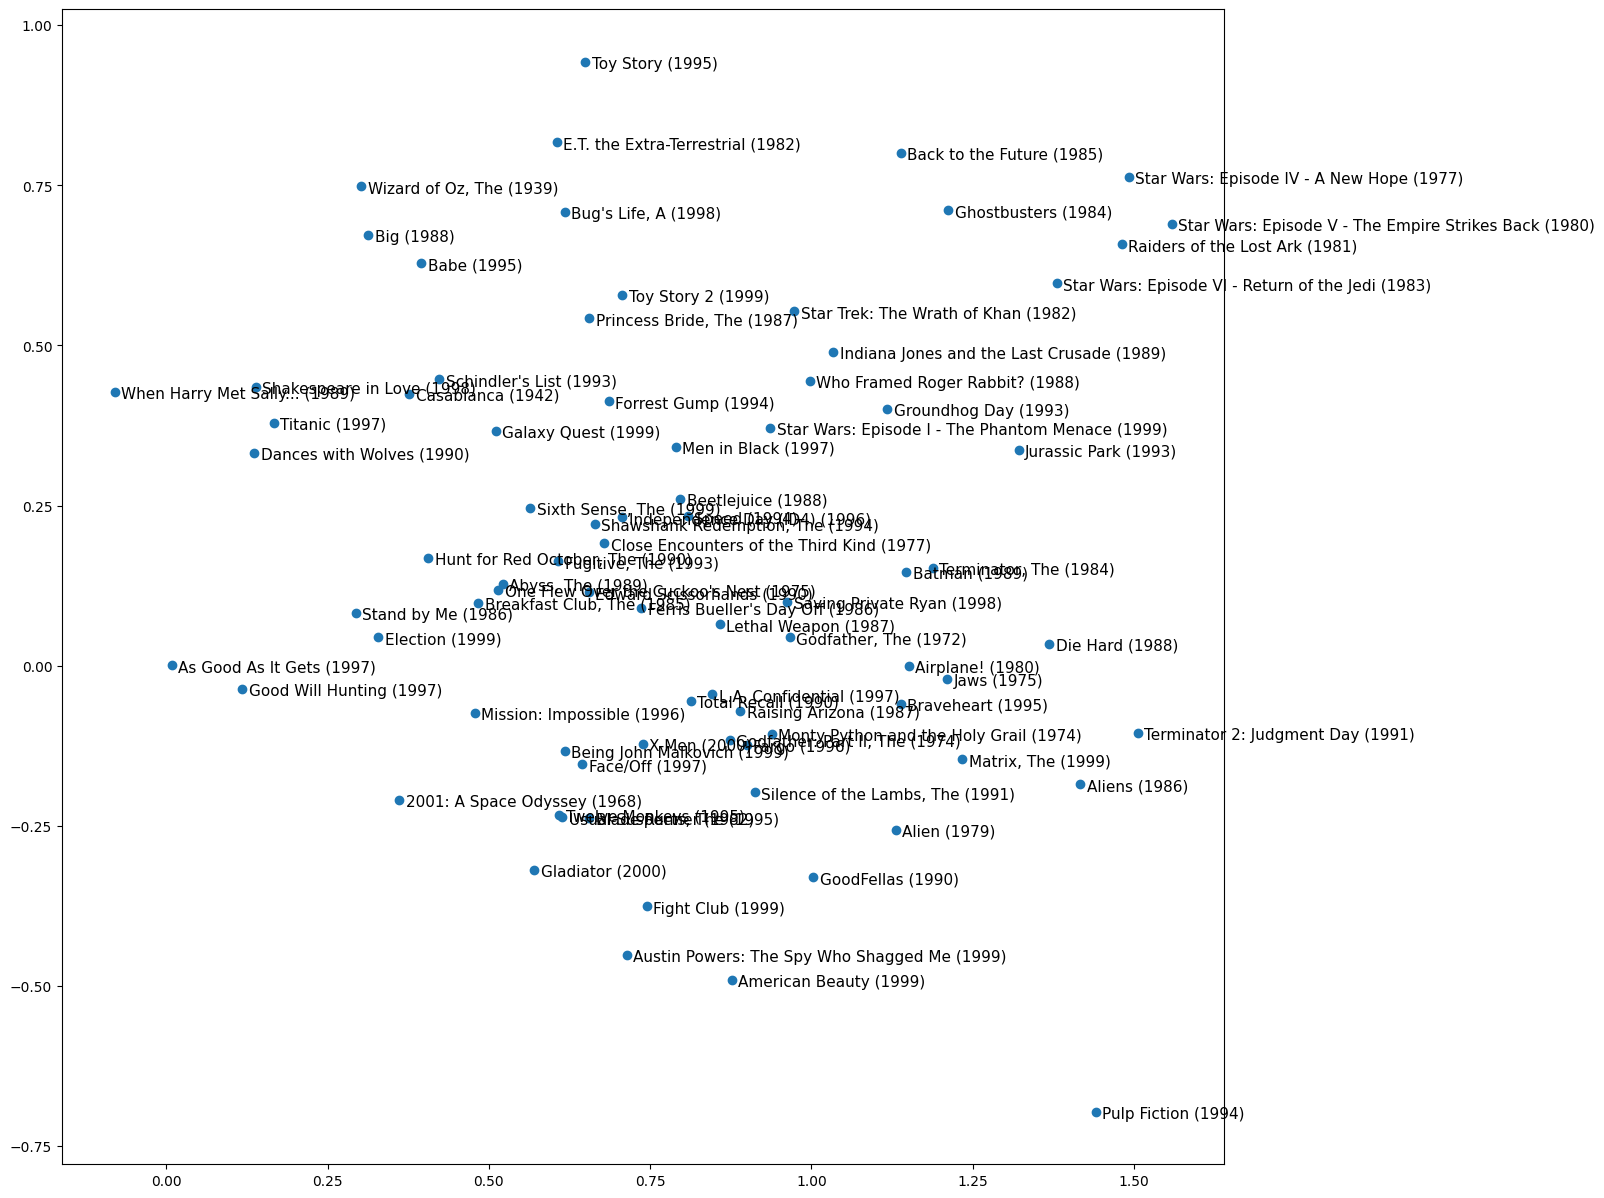

In [59]:
nums = most_rated_movies_num[:80]
txt_movies_names = [numitem_2_name[i] for i in nums]
X = latent_fac[nums,2]
Y = latent_fac[nums,3]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(txt_movies_names, X, Y):
    plt.text(x+0.01,y-0.01,i, fontsize=11)
plt.show()

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)